Số ảnh: clean=100 | noisy=100 | số cặp=1000
{'wavelet': 'db2', 'level': 2, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.588 SENS=0.614 SPEC=0.562 AUC=0.635 THR=123.0
{'wavelet': 'db4', 'level': 2, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.537 SENS=0.576 SPEC=0.498 AUC=0.575 THR=123.0
{'wavelet': 'sym4', 'level': 2, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.568 SENS=0.598 SPEC=0.538 AUC=0.619 THR=123.0
{'wavelet': 'coif1', 'level': 2, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.540 SENS=0.550 SPEC=0.530 AUC=0.591 THR=122.0
{'wavelet': 'haar', 'level': 2, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.605 SENS=0.642 SPEC=0.568 AUC=0.664 THR=120.0
{'wavelet': 'db2', 'level': 3, 'bits': 256, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.577 SENS=0.596 SPEC=0.558 AUC=0.640 THR=126.0
{'wavelet': 'db2', 'level': 2, 'bits': 512, 'thresh': 'median', 'resize': (128, 128)} -> ACC=0.567 SENS=0.

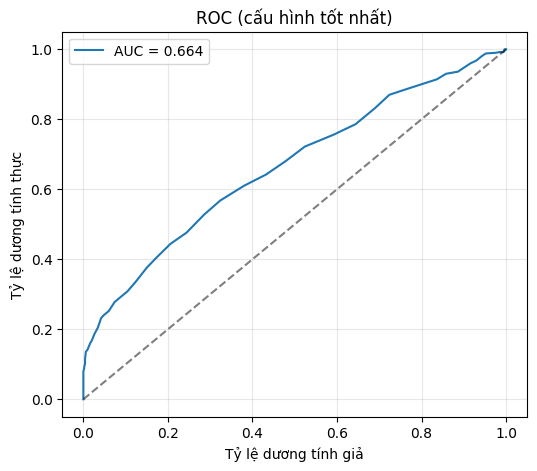


Xây dựng chỉ mục thư viện (CLEAN + NOISY)...
Ảnh truy vấn: obj1__0.png
d=   0 | oid=  1 | obj1__0.png | src=clean
d=  53 | oid=  1 | obj1__5.png | src=clean
d=  61 | oid=  6 | obj6__0.png | src=clean
d=  63 | oid=  6 | obj6__10.png | src=clean
d=  64 | oid=  4 | obj4__15.png | src=clean
d=  64 | oid= 16 | obj16__15.png | src=clean
d=  64 | oid= 19 | obj19__5.png | src=clean
d=  67 | oid=  4 | obj4__20.png | src=clean
d=  68 | oid= 16 | obj16__10.png | src=clean
d=  68 | oid= 16 | obj16__20.png | src=clean
d=  68 | oid= 18 | obj18__5.png | src=clean
d=  69 | oid=  5 | obj5__5.png | src=clean
d=  69 | oid= 16 | obj16__5.png | src=clean
d=  70 | oid= 16 | obj16__0.png | src=clean
d=  70 | oid= 18 | obj18__0.png | src=clean
d=  70 | oid= 19 | obj19__0.png | src=clean
d=  71 | oid=  3 | obj3__5.png | src=clean
d=  71 | oid=  4 | obj4__10.png | src=clean
d=  71 | oid=  6 | obj6__5.png | src=clean
d=  72 | oid= 13 | obj13__20.png | src=clean


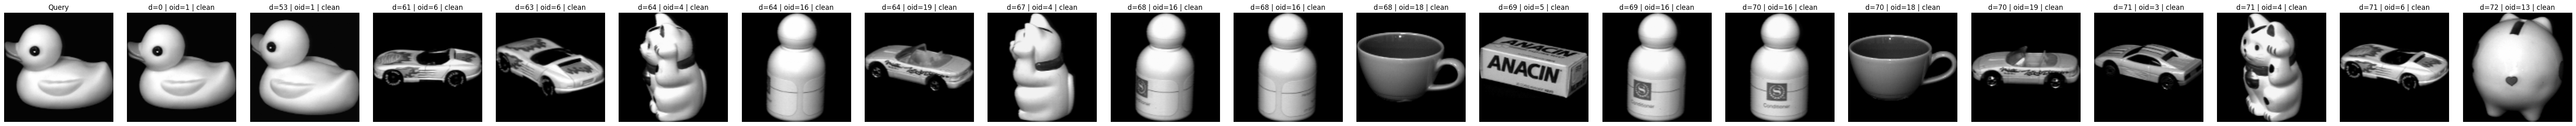

In [16]:
# ===============================
# Bài thực hành: Băm wavelet & tìm kiếm ảnh
# ===============================

import os
import re
import numpy as np
import pywt
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# -------------------------------
# Cấu hình dữ liệu & khảo sát
# -------------------------------
# Lưu ý: KHÔNG có khoảng trắng thừa sau "test img"
CLEAN_DIR = "/content/test img/coil-20"
NOISY_DIR = "/content/test img/coil-20 noisy"

CONFIGS = [
    {"wavelet":"db2","level":2,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"db4","level":2,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"sym4","level":2,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"coif1","level":2,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"haar","level":2,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"db2","level":3,"bits":256,"thresh":"median","resize":(128,128)},
    {"wavelet":"db2","level":2,"bits":512,"thresh":"median","resize":(128,128)},
    {"wavelet":"db2","level":2,"bits":256,"thresh":"mean","resize":(128,128)},
]

# -------------------------------
# Tiện ích: đọc ảnh & gán nhãn
# -------------------------------
def check_dir(path):
    """Kiểm tra thư mục tồn tại và có ảnh."""
    if not os.path.isdir(path):
        print(f"[Cảnh báo] Thư mục không tồn tại: {path}")
        return False
    files = os.listdir(path)
    imgs = [f for f in files if os.path.splitext(f)[1].lower() in {".png",".jpg",".jpeg",".bmp"}]
    if len(imgs) == 0:
        print(f"[Cảnh báo] Không tìm thấy ảnh trong: {path}")
        return False
    return True

def list_images_with_id(dir_path, exts={".png",".jpg",".jpeg",".bmp"}):
    """
    Liệt kê ảnh và suy ra nhãn (object ID) từ tên file.
    - Ưu tiên dạng 'obj12__0.png' → nhãn 12.
    - Nếu không có, lấy số đầu tiên xuất hiện trong tên file.
    """
    out=[]
    if not os.path.isdir(dir_path):
        return out
    for f in os.listdir(dir_path):
        ext = os.path.splitext(f)[1].lower()
        if ext in exts:
            path = os.path.join(dir_path, f)
            m = re.search(r"obj(\d+)", f, re.IGNORECASE) or re.search(r"(\d+)", f)
            oid = int(m.group(1)) if m else -1
            if oid>=0:
                out.append((path, oid))
    return sorted(out, key=lambda x:(x[1],x[0]))

def load_gray(path, size=(128,128)):
    """Tải ảnh, chuyển về xám, resize, chuẩn hóa về [0,1]."""
    img = Image.open(path).convert("L")
    img = img.resize(size, Image.BICUBIC)
    return np.asarray(img, dtype=np.float32)/255.0

# -------------------------------
# Wavelet: trích xuất & băm
# -------------------------------
def wavelet_features(img_arr, wavelet='db2', level=2):
    """
    Biến đổi wavelet 2D.
    - coeffs[0]: LL (mô tả cấu trúc tổng quát, ổn định).
    - coeffs[1:]: LH, HL, HH (chi tiết/biên).
    Trả về vector đặc trưng 1D (ghép các băng).
    """
    coeffs = pywt.wavedec2(img_arr, wavelet=wavelet, level=level)
    feats = [coeffs[0].ravel()]
    for (LH, HL, HH) in coeffs[1:]:
        feats += [LH.ravel(), HL.ravel(), HH.ravel()]
    return np.concatenate(feats).astype(np.float32)

def to_bits(feats, bits=256, thresh='median'):
    """
    Lượng tử hóa hệ số → mã băm nhị phân cố định độ dài.
    - Nếu dài hơn 'bits': lấy mẫu đều.
    - Nếu ngắn hơn: lặp (tile) cho đủ.
    - Ngưỡng: median (mặc định) hoặc mean.
    """
    L = len(feats)
    if L == 0:
        return np.zeros(bits, dtype=np.uint8)
    if L > bits:
        idx = np.linspace(0, L-1, bits).astype(int)
        feats = feats[idx]
    elif L < bits:
        reps = int(np.ceil(bits/L))
        feats = np.tile(feats, reps)[:bits]
    t = np.median(feats) if thresh=='median' else np.mean(feats)
    return (feats >= t).astype(np.uint8)

def wavelet_hash(path, wavelet='db2', level=2, bits=256, resize=(128,128), thresh='median'):
    """Pipeline: load ảnh → wavelet → mã băm."""
    arr = load_gray(path, size=resize)
    feats = wavelet_features(arr, wavelet=wavelet, level=level)
    return to_bits(feats, bits=bits, thresh=thresh)

# -------------------------------
# So sánh & đánh giá
# -------------------------------
def hamming(h1, h2):
    """Khoảng cách Hamming giữa 2 mã băm."""
    L = min(len(h1), len(h2))
    return int(np.sum(h1[:L] != h2[:L]))

def make_pairs(clean, noisy):
    """
    Tạo cặp so sánh:
    - Positive (label=1): cùng object ID giữa clean và noisy.
    - Negative (label=0): khác object ID, cân bằng số lượng với positive.
    """
    from collections import defaultdict
    by_clean, by_noisy = defaultdict(list), defaultdict(list)
    for p, oid in clean: by_clean[oid].append(p)
    for p, oid in noisy: by_noisy[oid].append(p)

    pairs=[]
    # Positive
    for oid in sorted(by_clean.keys()):
        if oid in by_noisy:
            for pc in by_clean[oid]:
                for pn in by_noisy[oid]:
                    pairs.append((pc, pn, 1))
    # Negative (cân bằng với positive)
    pos = [p for p in pairs if p[2]==1]
    neg=[]
    o_clean = sorted(by_clean.keys()); o_noisy = sorted(by_noisy.keys())
    rng = np.random.default_rng(42)
    while len(neg) < len(pos) and o_clean and o_noisy:
        oc = rng.choice(o_clean); on = rng.choice(o_noisy)
        if oc == on: continue
        pc = rng.choice(by_clean[oc]); pn = rng.choice(by_noisy[on])
        neg.append((pc, pn, 0))
    return pos + neg

def evaluate(pairs, hash_params):
    """
    Tính khoảng cách, dự đoán theo ngưỡng median, và các chỉ số:
    - Accuracy, Sensitivity (Recall), Specificity
    - ROC & AUC
    """
    dists=[]; labels=[]
    for p1, p2, lab in pairs:
        h1 = wavelet_hash(p1, **hash_params)
        h2 = wavelet_hash(p2, **hash_params)
        dists.append(hamming(h1,h2)); labels.append(lab)

    dists = np.array(dists); labels = np.array(labels)
    thr = np.median(dists)
    preds = (dists <= thr).astype(int)

    TP = np.sum((preds==1)&(labels==1))
    TN = np.sum((preds==0)&(labels==0))
    FP = np.sum((preds==1)&(labels==0))
    FN = np.sum((preds==0)&(labels==1))

    acc = (TP+TN)/max(len(labels),1)
    sens = TP/max(TP+FN,1)
    spec = TN/max(TN+FP,1)

    scores = -dists.astype(np.float32)  # khoảng cách nhỏ → điểm cao
    fpr, tpr, _ = roc_curve(labels, scores)
    AUC = auc(fpr, tpr)

    return dict(
        acc=acc, sens=sens, spec=spec, auc=AUC, thr=thr,
        fpr=fpr, tpr=tpr, dists=dists, labels=labels
    )

def plot_roc(fpr, tpr, auc_val, title="Đường cong ROC"):
    """Vẽ ROC curve."""
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel("Tỷ lệ dương tính giả")
    plt.ylabel("Tỷ lệ dương tính thực")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# -------------------------------
# Ứng dụng tìm kiếm ảnh (top-k) với nhãn nguồn
# -------------------------------
def build_index(dir_path, hash_params, label):
    """Xây chỉ mục mã băm cho thư viện ảnh, kèm nhãn nguồn (clean/noisy)."""
    items = list_images_with_id(dir_path)
    index=[]
    for path, oid in items:
        h = wavelet_hash(path, **hash_params)
        index.append((path, oid, h, label))
    return index

def search(query_path, index, hash_params, topk=20):
    """Tìm ảnh tương tự theo khoảng cách Hamming (trả về kèm nhãn nguồn)."""
    hq = wavelet_hash(query_path, **hash_params)
    scored=[]
    for path, oid, h, label in index:
        d = hamming(hq, h)
        scored.append((d, path, oid, label))
    scored.sort(key=lambda x: x[0])
    return scored[:topk]

def show_results(query_path, results):
    """Hiển thị ảnh truy vấn và top-k kết quả (có nhãn nguồn)."""
    fig, axs = plt.subplots(1, len(results)+1, figsize=(3*(len(results)+1),3))
    axs[0].imshow(Image.open(query_path).convert("L"), cmap='gray')
    axs[0].set_title("Query")
    axs[0].axis('off')
    for i, (d, p, oid, label) in enumerate(results, start=1):
        axs[i].imshow(Image.open(p).convert("L"), cmap='gray')
        axs[i].set_title(f"d={d} | oid={oid} | {label}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# -------------------------------
# Chạy toàn bộ chương trình
# -------------------------------
def main():
    # Kiểm tra thư mục
    ok_clean = check_dir(CLEAN_DIR)
    ok_noisy = check_dir(NOISY_DIR)
    if not (ok_clean and ok_noisy):
        print("→ Vui lòng kiểm tra lại đường dẫn/thư mục dữ liệu trước khi chạy.")
        return

    clean = list_images_with_id(CLEAN_DIR)
    noisy = list_images_with_id(NOISY_DIR)
    if len(clean)==0 or len(noisy)==0:
        print("→ Không có ảnh hợp lệ để chạy. Kiểm tra định dạng tên và phần mở rộng.")
        return

    pairs = make_pairs(clean, noisy)
    if len(pairs)==0:
        print("→ Không tạo được cặp so sánh (có thể do không khớp nhãn giữa hai thư mục).")
        return

    print(f"Số ảnh: clean={len(clean)} | noisy={len(noisy)} | số cặp={len(pairs)}")

    # Khảo sát cấu hình
    results=[]
    for cfg in CONFIGS:
        r = evaluate(pairs, cfg)
        results.append((cfg, r))
        print(f"{cfg} -> ACC={r['acc']:.3f} SENS={r['sens']:.3f} SPEC={r['spec']:.3f} AUC={r['auc']:.3f} THR={r['thr']:.1f}")

    # Chọn cấu hình tốt nhất theo AUC
    best_cfg, best_res = max(results, key=lambda x: x[1]['auc'])
    print("\nCấu hình tốt nhất:", best_cfg, f"AUC={best_res['auc']:.3f}")

    # Vẽ ROC cho cấu hình tốt nhất
    plot_roc(best_res['fpr'], best_res['tpr'], best_res['auc'], title="ROC (cấu hình tốt nhất)")

    # Xây dựng ứng dụng tìm kiếm ảnh (clean + noisy)
    print("\nXây dựng chỉ mục thư viện (CLEAN + NOISY)...")
    index = build_index(CLEAN_DIR, best_cfg, "clean") + build_index(NOISY_DIR, best_cfg, "noisy")
    if len(index)==0:
        print("→ Không xây được chỉ mục vì thư mục trống.")
        return

    # Dùng ảnh đầu tiên làm truy vấn minh họa
    query_path = index[0][0]
    print("Ảnh truy vấn:", os.path.basename(query_path))
    top = search(query_path, index, best_cfg, topk=20)
    for d, p, oid, label in top:
        print(f"d={d:4d} | oid={oid:3d} | {os.path.basename(p)} | src={label}")
    show_results(query_path, top)

# Gọi main
if __name__ == "__main__":
    main()
